In [2]:
import os
import sys
from pathlib import Path
import re
import pandas as pd
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.database_handler import DatabaseHandler, DatabaseExecutor
from src.utils import timer

import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Generierung der Allgemeinen Größen für Beschriftung und Diagramme:
ls_head = 20 # Überschrift
ls_axis = 18 # x/y-Beschriftung
ls_font = 16 # Schrif (zB .text)
ls_label = 16 # Werte x/y-Achse
ls_legend = 16 # Schriftgröße der Legende
figsize = (20,8)
figsize2 = (13,6)
facecolor = 'grey'
facecolor2 = 'blue'
alpha = 0.15
alpha2 = 0.30
alphalegend = 0.9
s_dpi = 300

# Übergabe in ein Dict und anschließend aktualisieren der Parameter
rc={'figure.figsize': figsize,
    'legend.framealpha': alphalegend,
    'axes.labelsize': ls_axis, 'font.size': ls_font, 'legend.fontsize': ls_legend,
    'axes.titlesize': ls_head, 'xtick.labelsize': ls_label, 'ytick.labelsize': ls_label,
    'grid.color': 'k', 'grid.linestyle': '--',
    "savefig.dpi": s_dpi, "savefig.format": 'svg' }
plt.rcParams.update(**rc)

In [3]:
# For station Files
station_col_specs = [
    (0,  12),
    (12, 21),
    (21, 31),
    (31, 38),
    (38, 41),
    (41, 72),
    (72, 76),
    (76, 80),
    (80, 86)
]

station_names = [
    "ID",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "STATE",
    "NAME",
    "GSN FLAG",
    "HCN/CRN FLAG",
    "WMO ID"]

station_dtype = {
    "ID": str,
    "STATE": str,
    "NAME": str,
    "GSN FLAG": str,
    "HCN/CRN FLAG": str,
    "WMO ID": str
    }

# For Weather files
data_header_names = [
    "ID",
    "YEAR",
    "MONTH",
    "ELEMENT"]

data_header_col_specs = [
    (0,  11),
    (11, 15),
    (15, 17),
    (17, 21)]

data_header_dtypes = {
    "ID": str,
    "YEAR": int,
    "MONTH": int,
    "ELEMENT": str}

# create nested list and expand to list
data_col_names = [[
    f"VALUE{i + 1}",
    f"MFLAG{i + 1}",
    f"QFLAG{i + 1}",
    f"SFLAG{i + 1}"]
    for i in range(31)]
data_col_names = sum(data_col_names, [])

data_replacement_col_names = [[
    ("VALUE", i + 1),
    ("MFLAG", i + 1),
    ("QFLAG", i + 1),
    ("SFLAG", i + 1)]
    for i in range(31)]
data_replacement_col_names = sum(data_replacement_col_names, [])
data_replacement_col_names = pd.MultiIndex.from_tuples(
    data_replacement_col_names,
    names=['VAR_TYPE', 'DAY'])

data_col_specs = [[
    (21 + i * 8, 26 + i * 8),
    (26 + i * 8, 27 + i * 8),
    (27 + i * 8, 28 + i * 8),
    (28 + i * 8, 29 + i * 8)]
    for i in range(31)]
data_col_specs = sum(data_col_specs, [])

data_col_dtypes = [{
    f"VALUE{i + 1}": int,
    f"MFLAG{i + 1}": str,
    f"QFLAG{i + 1}": str,
    f"SFLAG{i + 1}": str}
    for i in range(31)]
# unpacks each dict in the list to key value in the main dict
data_header_dtypes.update({k: v for d in data_col_dtypes for k, v in d.items()})

In [4]:
def read_ghcn_data_file(filename="ACW00011604.dly",
                        variables=None, include_flags=False,
                        dropna='all'):
    """Variables can be a list of names like ['TMIN', 'TMAX', 'TOBS']"""
    df = pd.read_fwf(
        filename,
        colspecs=data_header_col_specs + data_col_specs,
        names=data_header_names + data_col_names,
        index_col=data_header_names,
        dtype=data_header_dtypes
        )

    # Drops all values not included in list
    if variables is not None:
        df = df[df.index.get_level_values('ELEMENT').isin(variables)]

    df.columns = data_replacement_col_names

    # drops every column exept the value (other ones are flag values, see readme of the data, often NaN anyway)
    if not include_flags:
        df = df.loc[:, ('VALUE', slice(None))]
        df.columns = df.columns.droplevel('VAR_TYPE')

    # to row by day, spread TMIN, TMAX, ... into columns
    df = df.stack(level='DAY').unstack(level='ELEMENT')

    # drop the NaN values (-9999 are also missing values in the data set)
    if dropna:
        df.replace(-9999.0, np.nan, inplace=True)
        df.replace(-9999, np.nan, inplace=True)
        df.dropna(how=dropna, inplace=True)
    
    # see https://pandas.pydata.org/docs/user_guide/timeseries.html also for more info
    # it's an int 64 repr you can quick forward on the side if you search "int64 based YYYYMMDD"
    df.index = pd.to_datetime(
        df.index.get_level_values('YEAR') * 10000 +
        df.index.get_level_values('MONTH') * 100 +
        df.index.get_level_values('DAY'),
        format='%Y%m%d')

    return df

In [4]:
def df_from_json(json_file_path):
    df_json_file = pd.read_json(json_file_path, lines= True)
    return df_json_file

def read_and_clean_business():
    print("Starting to read business data to dataframe")
    df = df_from_json("yelp_academic_dataset_business.json")
    df.categories = df.categories.str.split(", ")
    return df

def read_and_clean_users(sliced_file):
    print(f"Starting to read user data to dataframe for {sliced_file}")
    df = df_from_json(sliced_file)
    df.elite = df.elite.str.split(",")
    df.friends = df.friends.str.split(", ")
    return df

def read_and_clean_reviews(sliced_file):
    print(f"Starting to read review data to dataframe for {sliced_file}")
    df = df_from_json(sliced_file)
    df.date = df.date.dt.strftime("%Y-%m-%d")
    return df

def read_and_clean_tips():
    print("Starting to read tip data to dataframe")
    df = df_from_json("yelp_academic_dataset_tip.json")
    df.date = df.date.dt.strftime('%Y-%m-%d')
    return df

def generate_day_feq(x):
    dates = x["date"]
    onlydates = []
    for x in dates:
        dat, _ = x.split(" ")
        onlydates.append(dat)
    ser = pd.Series(onlydates)
    return [[d,v] for (d,v) in ser.value_counts().iteritems()]

def read_and_clean_checkins():
    print("Starting to read tip data to dataframe")
    df = df_from_json("yelp_academic_dataset_checkin.json")
    df.date = df.date.str.split(", ")
    df["date"] = df.apply(generate_day_feq, axis=1)
    return df

# For business
def generate_category_dict(category_column):
    allcats = []
    for i, val in enumerate(category_column):
        if val is not None:
            allcats.extend(val)
    setcat = set(allcats)
    dictcat = {x:i+1 for i,x in enumerate(setcat)}
    return dictcat

def generate_categories(dictcat:dict):
    return [(cid, cat) for cat,cid in dictcat.items()]

def generate_category_info(business_id:str, dictcat:dict, categories:list):
    datalist = []
    if categories is None:
        return datalist
    # in some cases there can be the same cat entered twice.
    for cat in list(set(categories)):
        datalist.append((business_id, dictcat[cat]))
    return datalist

def map_dow(day: str):
    mapping = {
        "Monday": 0,
        'Tuesday': 1,
        'Wednesday': 2,
        'Thursday': 3,
        'Friday': 4,
        'Saturday': 5,
        'Sunday': 6,
    }
    return mapping.get(day, None)

def generate_time_info(business_id:str, timedict:dict):
    datalist = []
    if timedict is None:
        return datalist
    for day, timestring in timedict.items():
        start, end = timestring.split("-")
        start_1, start_2 = start.split(":")
        start_1 = start_1.rjust(2, "0")
        start_2 = start_2.ljust(2, "0")
        end_1, end_2 = end.split(":")
        end_1 = end_1.rjust(2, "0")
        end_2 = end_2.ljust(2, "0")
        data = (business_id, map_dow(day), f"{start_1}:{start_2}", f"{end_1}:{end_2}")
        datalist.append(data)
    return datalist

def generate_attribute_list(dict_categories, bid):
    data_list = []
    important_key_names = [
        "BusinessParking",
        "RestaurantsTableService",
        "Open24Hours",
        "RestaurantsCounterService",
        "DriveThru",
        "HappyHour",
        "OutdoorSeating",
        "RestaurantsGoodForGroups",
        "RestaurantsReservations",
        "Caters",
    ]
    if dict_categories is None:
        return []
    for key, value in dict_categories.items():
        if key in important_key_names:
            if value is None or value=="None":
                continue
            if "True" in value:
                data_list.append((bid,key))
    return data_list

# for user
def count_compliments(data):
    columns_to_include = [
        "compliment_hot",
        "compliment_more",
        "compliment_profile",
        "compliment_cute",
        "compliment_list",
        "compliment_note",
        "compliment_plain",
        "compliment_cool",
        "compliment_funny",
        "compliment_writer",
        "compliment_photos",
    ]
    return data[columns_to_include].sum()

def count_evaluations(data):
    columns_to_include = [
        "useful",
        "funny",
        "cool",
    ]
    return data[columns_to_include].sum()

def count_friends(data):
    return len(data["friends"])

def count_elite_years(data):
    return len(data["elite"])

def get_yelping_start(data):
    full_ts = data["yelping_since"]
    day, time = full_ts.split(" ")
    return day

# for reviews
# we can use count_evaluations here as well :)

# for checkins
def generate_checkin_data(data):
    list_of_dates = data["date"]
    if list_of_dates is None:
        return []
    business_id = data["business_id"]
    data_list = [(business_id, x[0], x[1]) for x in list_of_dates]
    return data_list

In [5]:
class DataPreparator():
    def __init__(self):
        self.__handler = DatabaseHandler()
        self.__querry = self.__handler.querry_database
        self.__insert_many = self.__handler.insert_many
    
    @timer
    def insert_stations(self, filename="ghcnd-stations.txt"):
        print(f"Inserting stations from {filename}. Please be patient....")
        datalist = []
        sql = "INSERT INTO STATIONDATA(SID, LON, LAT, ELE, STATE, NAME) VALUES %s"
        df = pd.read_fwf(filename, station_col_specs, names=station_names, dtype=station_dtype)
        for _, row in df.iterrows():
            used_state = ""
            if pd.notna(row["STATE"]):
                used_state = row["STATE"]
            data =  (
                row["ID"],
                row["LONGITUDE"],
                row["LATITUDE"],
                row["ELEVATION"],
                used_state,
                row["NAME"]
            )
            datalist.append(data)
        self.__insert_many(sql, datalist)
    
    @timer
    def insert_weather(self, folderpath=None):
        start_date =  "2000-01-01"
        filefolder = folderpath
        if folderpath is None:
            try:
                dirpath = os.path.dirname(__file__)
                filefolder = os.path.join(dirpath, "ghcnd_hcn")
            except NameError:
                filefolder = "ghcnd_hcn"
        print(f"Extracting data from: {filefolder} to get weather data. This may take a while.")
        filelist = Path(filefolder).rglob('*.dly')
        selected_vars = ["TMIN", "TMAX", "TOBS", "PRCP", "SNOW", "SNWD"]
        error_files = []
        sql = "INSERT INTO WEATHER(SID, DATE, TMIN, TMAX, PERCEPTION, SNOW, SNOWDEPTH) VALUES %s"
        # iterate over each file in folder, generate datalist and finally make one big insert for each file to be time efficient
        for i, path in enumerate(filelist):
            try:
                str_path = str(path)
                find = re.search("(\w{11}).dly", str_path)
                station_id = find.group(1)
                print(f"Reading in {i+1}th file at: {str_path} | station: {station_id}")
                weather = read_ghcn_data_file(filename=str_path, variables=selected_vars)
                weather.TMIN = weather.TMIN/10
                weather.TMAX = weather.TMAX/10
                weather.PRCP = weather.PRCP/10
                weather.fillna(np.nan).replace([np.nan], [None])
                mask = (weather.index >= start_date)
                datalist = []
                for index, row in weather[mask].iterrows():
                    data = (
                        station_id,
                        index,
                        row["TMIN"],
                        row["TMAX"],
                        row["PRCP"],
                        row["SNOW"],
                        row["SNWD"]
                    )
                    datalist.append(data)
                self.__insert_many(sql, datalist)
            except KeyError:
                print(f"ERROR: There was an error getting one of the values at: {station_id}.")
                error_files.append(station_id)
        print("Done processing all files.")
        if len(error_files)>0:
            print("Problem in following files:")
            print(error_files)
            
    @timer
    def insert_business(self):
        df = read_and_clean_business()
        # generate all unique categories and sql data
        dictcat = generate_category_dict(df.categories)
        sql_cat = "INSERT INTO CATEGORIES(CID, CAT) VALUES %s"
        cat_data = generate_categories(dictcat)
        # generate all business data: business row, according hours and categories and now attributes as well
        sql_attributes = "INSERT INTO attribute(BID, ATTR) VALUES %s"
        attributes_data = []
        sql_business = "INSERT INTO BUSINESS(BID, CITY, STATE, PCODE, LON, LAT, STARS, REVCOUNT) VALUES %s"
        business_data = []
        sql_category_link = "INSERT INTO CATEGORY(BID, CID) VALUES %s"
        category_link_data = []
        sql_hour = "INSERT INTO HOURS(BID, DOW, OPEN, CLOSE) VALUES %s"
        hour_data = []
        print("Start preparing all business related data to insert to database ...")
        for _, row in df.iterrows():
            b_data = (
                row["business_id"],
                row["city"],
                row["state"],
                row["postal_code"],
                row["longitude"],
                row["latitude"],
                row["stars"],
                row["review_count"]
            )
            business_data.append(b_data)
            category_link_data.extend(generate_category_info(row["business_id"], dictcat, row["categories"]))
            attributes_data.extend(generate_attribute_list(row["attributes"], row["business_id"]))
            hour_data.extend(generate_time_info(row["business_id"], row["hours"]))
        # first insert all businesses, then cats, then the links and the hour data
        print("Done preparing, starting inserts")
        print("Inserting all business data ...")
        self.__insert_many(sql_business, business_data)
        print("Inserting all category data ...")
        self.__insert_many(sql_cat, cat_data)
        print("Inserting all links betweeen categories and business data ...")
        self.__insert_many(sql_category_link, category_link_data)
        print("Inserting all hour data of business ...")
        self.__insert_many(sql_hour, hour_data)   
        print("Insertting all attribute data of business ...")
        self.__insert_many(sql_attributes, attributes_data)
            
    @timer
    def insert_users(self):
        # The VM prob cant handle this big chunk eiter, so split this file as well
        filelist = Path('.').rglob('user_*')
        for user_file in filelist:
            str_path = str(user_file)
            df = read_and_clean_users(str_path)
            sql_user = "INSERT INTO USERS(UID, REVCOUNT, SINCE, FRIENDS, EVALCOUNT, FANS, ELITE, AVGSTARS, INTERACTION) VALUES %s"
            user_data = []
            print(f"Start preparing all user related data to insert to database from file {str_path} ...")
            for _, row in df.iterrows():  
                data = (
                    row["user_id"],
                    row["review_count"],
                    get_yelping_start(row),
                    count_friends(row),
                    count_evaluations(row),
                    row["fans"],
                    count_elite_years(row),
                    row["average_stars"],
                    count_compliments(row),
                )
                user_data.append(data)
            print(f"Inserting all data of user from file {str_path} ...")
            self.__insert_many(sql_user, user_data)
    
    @timer
    def insert_reviews(self):
        # reviews are too big, so they got split in separate files ^-^
        filelist = Path('.').rglob('review_*')
        for review_file in filelist:
            str_path = str(review_file)
            df = read_and_clean_reviews(str_path)
            sql_reviews = "INSERT INTO REVIEWS(RID, UID, BID, STAR, DATE, INTERACTIONS, TEXT) VALUES %s"
            review_data = []
            print(f"Start preparing all review related data to insert to database from file {str_path} ...")
            for _, row in df.iterrows():
                data = (
                    row["review_id"], 
                    row["user_id"], 
                    row["business_id"], 
                    row["stars"], 
                    row["date"], 
                    count_evaluations(row), 
                    row["text"], 
                )
                review_data.append(data)
            print(f"Inserting all data of reviews from file {str_path} ...")
            self.__insert_many(sql_reviews, review_data)
        
    @timer
    def insert_tips(self):
        df = read_and_clean_tips()
        sql_tips = "INSERT INTO TIPS(TID, BID, UID, COMPLIMENTS, DATE, TEXT) VALUES %s"
        tips_data = []
        print("Start preparing all tips related data to insert to database ...")
        for index, row in df.iterrows():
            data = (
                index,
                row["business_id"],
                row["user_id"],
                row["compliment_count"],
                row["date"],
                row["text"],
            )
            tips_data.append(data)
        print("Inserting all data of tips ...")
        self.__insert_many(sql_tips, tips_data)
    
    @timer
    def insert_checkins(self):
        df = read_and_clean_checkins()
        sql_checkins = "INSERT INTO CHECKINS(BID, DATE, AMOUNT) VALUES %s"
        checkins_data = []
        print("Start preparing all checkin related data to insert to database ...")
        for _, row in df.iterrows():
            checkins_data.extend(generate_checkin_data(row))
        print("Inserting all data of checkin ...")
        self.__insert_many(sql_checkins, checkins_data)

In [6]:
dp = DataPreparator()

In [6]:
# dp.insert_stations()

Inserting stations from ghcnd-stations.txt. Please be patient....
Elapsed time for 'insert_many': 3.6026 seconds


In [7]:
# dp.insert_weather()

Extracting data from: ghcnd_hcn to get weather data. This may take a while.
Reading in 1th file at: ghcnd_hcn\USC00011084.dly | station: USC00011084
Elapsed time for 'insert_many': 0.3054 seconds
Reading in 2th file at: ghcnd_hcn\USC00012813.dly | station: USC00012813
Elapsed time for 'insert_many': 0.6475 seconds
Reading in 3th file at: ghcnd_hcn\USC00013160.dly | station: USC00013160
Elapsed time for 'insert_many': 0.4018 seconds
Reading in 4th file at: ghcnd_hcn\USC00013511.dly | station: USC00013511
Elapsed time for 'insert_many': 0.5268 seconds
Reading in 5th file at: ghcnd_hcn\USC00013816.dly | station: USC00013816
Elapsed time for 'insert_many': 0.2435 seconds
Reading in 6th file at: ghcnd_hcn\USC00017157.dly | station: USC00017157
Elapsed time for 'insert_many': 0.4012 seconds
Reading in 7th file at: ghcnd_hcn\USC00017304.dly | station: USC00017304
Elapsed time for 'insert_many': 0.5535 seconds
Reading in 8th file at: ghcnd_hcn\USC00017366.dly | station: USC00017366
Elapsed tim

KeyError: 'SNOW'

In [7]:
# dp.insert_business()

Starting to read business data to dataframe
Start preparing all business related data to insert to database ...
Done preparing, starting inserts
Inserting all business data ...
Elapsed time for 'insert_many': 7.6613 seconds
Inserting all category data ...
Elapsed time for 'insert_many': 0.0316 seconds
Inserting all links betweeen categories and business data ...
Elapsed time for 'insert_many': 43.8787 seconds
Inserting all hour data of business ...
Elapsed time for 'insert_many': 38.9474 seconds
Insertting all attribute data of business ...
Elapsed time for 'insert_many': 7.7017 seconds
Elapsed time for 'insert_business': 124.5786 seconds


In [7]:
# dp.insert_users()

Starting to read user data to dataframe for user_a
Start preparing all user related data to insert to database from file user_a ...
Inserting all data of user from file user_a ...
Elapsed time for 'insert_many': 6.1164 seconds
Starting to read user data to dataframe for user_b
Start preparing all user related data to insert to database from file user_b ...
Inserting all data of user from file user_b ...
Elapsed time for 'insert_many': 6.4973 seconds
Starting to read user data to dataframe for user_c
Start preparing all user related data to insert to database from file user_c ...
Inserting all data of user from file user_c ...
Elapsed time for 'insert_many': 6.4107 seconds
Starting to read user data to dataframe for user_d
Start preparing all user related data to insert to database from file user_d ...
Inserting all data of user from file user_d ...
Elapsed time for 'insert_many': 5.9807 seconds
Starting to read user data to dataframe for user_e
Start preparing all user related data to 

In [31]:
# dp.insert_reviews()

Starting to read review data to dataframe for review_a
Start preparing all review related data to insert to database from file review_a ...
Inserting all data of reviews from file review_a ...
Elapsed time for 'insert_many': 39.3586 seconds
Starting to read review data to dataframe for review_b
Start preparing all review related data to insert to database from file review_b ...
Inserting all data of reviews from file review_b ...
Elapsed time for 'insert_many': 42.9298 seconds
Starting to read review data to dataframe for review_c
Start preparing all review related data to insert to database from file review_c ...
Inserting all data of reviews from file review_c ...
Elapsed time for 'insert_many': 45.1850 seconds
Starting to read review data to dataframe for review_d
Start preparing all review related data to insert to database from file review_d ...
Inserting all data of reviews from file review_d ...
Elapsed time for 'insert_many': 45.8218 seconds
Starting to read review data to data

In [63]:
# dp.insert_tips()

Starting to read tip data to dataframe
Start preparing all tips related data to insert to database ...
Inserting all data of tips ...
Elapsed time for 'insert_many': 96.9753 seconds
Elapsed time for 'insert_tips': 194.0801 seconds


In [7]:
# dp.insert_checkins()

Starting to read tip data to dataframe
Start preparing all checkin related data to insert to database ...
Inserting all data of checkin ...
Elapsed time for 'insert_many': 559.2997 seconds
Elapsed time for 'insert_checkins': 689.8764 seconds


In [6]:
tdf = read_and_clean_business()
tdf.head()

Starting to read business data to dataframe


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","[Active Life, Gun/Rifle Ranges, Guns & Ammo, S...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","[Health & Medical, Fitness & Instruction, Yoga...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"[Pets, Pet Services, Pet Groomers]",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","[Hardware Stores, Home Services, Building Supp...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","[Home Services, Plumbing, Electricians, Handym...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


In [18]:
def count_bis(x):
    if x is None:
        return 0
    myval = 0
    for v in x:
        if v == "Restaurants":
            myval += 1
    return myval

tdf.categories.apply(count_bis).sum()

63944

In [14]:
tdf.categories[123123]

['Restaurants', 'Mexican']

In [9]:
tdf.name.apply(lambda x: len(x)).max()

64

In [12]:
testlist = []
for _, row in tdf.iterrows():
    testlist.extend(generate_attribute_list(row["attributes"], row["business_id"]))

In [13]:
testlist[0:20]

[('f9NumwFMBDn751xgFiRbNA', 'BusinessParking'),
 ('6OAZjbxqM5ol29BuHsil3w', 'BusinessParking'),
 ('oiAlXZPIFm2nBCt0DHLu_Q', 'BusinessParking'),
 ('M_guz7Dj7hX0evS672wIwA', 'Caters'),
 ('M_guz7Dj7hX0evS672wIwA', 'BusinessParking'),
 ('uZuh51lXu7tsrC8RAwkg1A', 'BusinessParking'),
 ('Vwo64kNYDjKi98gUUv4-iQ', 'BusinessParking'),
 ('CsLQLiRoafpJPJSkNX2h5Q', 'RestaurantsGoodForGroups'),
 ('eBEfgOPG7pvFhb2wcG9I7w', 'BusinessParking'),
 ('eBEfgOPG7pvFhb2wcG9I7w', 'Caters'),
 ('9sRGfSVEfLhN_km60YruTA', 'Caters'),
 ('9sRGfSVEfLhN_km60YruTA', 'BusinessParking'),
 ('9sRGfSVEfLhN_km60YruTA', 'RestaurantsTableService'),
 ('9sRGfSVEfLhN_km60YruTA', 'OutdoorSeating'),
 ('9sRGfSVEfLhN_km60YruTA', 'RestaurantsReservations'),
 ('pcaQDBM6r0PWTXfYZK6RdA', 'Caters'),
 ('vjTVxnsQEZ34XjYNS-XUpA', 'RestaurantsGoodForGroups'),
 ('vjTVxnsQEZ34XjYNS-XUpA', 'BusinessParking'),
 ('UqBTL1dq9QcOISikgeknow', 'BusinessParking'),
 ('fnZrZlqW1Z8iWgTVDfv_MA', 'RestaurantsGoodForGroups')]

In [11]:
def myfun(x):
    if x is None: 
        return {} 
    else:
        return x
tdf.attributes = tdf.attributes.apply(myfun)

In [12]:
attr = tdf.attributes
attr

0         {'BusinessAcceptsCreditCards': 'True', 'BikePa...
1         {'GoodForKids': 'True', 'ByAppointmentOnly': '...
2                                                        {}
3         {'BusinessAcceptsCreditCards': 'True', 'ByAppo...
4         {'BusinessAcceptsCreditCards': 'True', 'ByAppo...
                                ...                        
209388    {'Ambience': '{'romantic': False, 'intimate': ...
209389    {'RestaurantsPriceRange2': '1', 'BusinessParki...
209390    {'BusinessAcceptsCreditCards': 'True', 'Restau...
209391                                                   {}
209392                                                   {}
Name: attributes, Length: 209393, dtype: object

In [13]:
attdf = pd.DataFrame(tdf.pop('attributes').tolist())

In [32]:
only_val = attdf["BusinessParking"].dropna()
only_val

0         {'garage': False, 'street': False, 'validated'...
3         {'garage': False, 'street': False, 'validated'...
6         {'garage': False, 'street': False, 'validated'...
8                                                      None
9         {'garage': False, 'street': False, 'validated'...
                                ...                        
209383    {'garage': False, 'street': False, 'validated'...
209385    {'garage': False, 'street': False, 'validated'...
209388    {'garage': False, 'street': False, 'validated'...
209389    {'garage': False, 'street': False, 'validated'...
209390    {'garage': False, 'street': False, 'validated'...
Name: BusinessParking, Length: 115215, dtype: object

In [42]:
import json
used_lines = 0
dropped_lines = 0
for _, r in only_val.iteritems():
    if r is None or r == "None":
        dropped_lines += 1
        continue
    r_d = r.replace("'",'"').replace("True", "true").replace("False", "false").replace("None", "false")
    r_d = json.loads(r_d)
    anytrue = False
    for k,v in r_d.items():
        if v:
            used_lines += 1
            anytrue = True
            break
    if not anytrue:
        dropped_lines += 1
        

print(f"Used: {used_lines} | dropped: {dropped_lines}")

Used: 68008 | dropped: 47207


In [16]:
attdf.iloc[0]["BusinessParking"]

"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"

In [17]:
attr[0]

{'BusinessAcceptsCreditCards': 'True',
 'BikeParking': 'True',
 'GoodForKids': 'False',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
 'ByAppointmentOnly': 'False',
 'RestaurantsPriceRange2': '3'}

In [18]:
attdf["BusinessAcceptsCreditCards"].value_counts()

True     115361
False      6785
None         91
Name: BusinessAcceptsCreditCards, dtype: int64

In [19]:
type(attr[0]["BusinessAcceptsCreditCards"])

str

In [20]:
import json
all_dict = {}
list_of_dict_names = ["BusinessParking", "Ambience", "GoodForMeal", "BestNights", "Music", "DietaryRestrictions", "HairSpecializesIn"]
for _, row in attr.iteritems():
    if row is None:
        continue
    for key, value in row.items():
        if key not in list_of_dict_names:
            if key not in all_dict:
                all_dict[key] = []
            if value not in all_dict[key]:
                all_dict[key].append(value)
        else:
            if value is None or value=="None":
                continue
            if key not in all_dict:
                all_dict[key] = {}
            conv_string = value.replace("'",'"').replace("True", "true").replace("False", "false").replace("None", "false")
            try:
                conv_json = json.loads(conv_string)
            except:
                print(key, conv_string)
            for k, v in conv_json.items():
                if k not in all_dict[key]:
                    all_dict[key][k] = []
                if v not in all_dict[key][k]:
                    all_dict[key][k].append(v)

In [21]:
for key, value in all_dict.items():
    print(f"{key.ljust(30)} |    {value}")

BusinessAcceptsCreditCards     |    ['True', 'False', 'None']
BikeParking                    |    ['True', 'False', 'None']
GoodForKids                    |    ['False', 'True', 'None']
BusinessParking                |    {'garage': [False, True], 'street': [False, True], 'validated': [False, True], 'lot': [True, False], 'valet': [False, True]}
ByAppointmentOnly              |    ['False', 'True', 'None']
RestaurantsPriceRange2         |    ['3', '4', '1', '2', 'None']
DogsAllowed                    |    ['True', 'False', 'None']
WiFi                           |    ["u'no'", "u'free'", "'no'", "'free'", "u'paid'", "'paid'", 'None']
RestaurantsAttire              |    ["u'casual'", "'casual'", "u'formal'", "u'dressy'", 'None', "'dressy'", "'formal'"]
RestaurantsTakeOut             |    ['True', 'False', 'None']
NoiseLevel                     |    ["u'quiet'", "u'average'", "u'loud'", "u'very_loud'", "'average'", "'quiet'", "'loud'", "'very_loud'", 'None']
RestaurantsReservations        

In [25]:
str(all_dict["AgesAllowed"][0])

"u'allages'"

In [20]:
somestr = "sdsdfsdf True sgsdfsdf"
"True" in somestr

True

In [10]:
max(tdf.city.str.len())

43

In [6]:
dictcat = generate_category_dict(tdf.categories)
generate_categories(dictcat)

[(1, 'Kebab'),
 (2, 'Medical Law'),
 (3, 'Organic Stores'),
 (4, 'International Grocery'),
 (5, 'Oaxacan'),
 (6, 'Boot Camps'),
 (7, 'Tacos'),
 (8, 'Shutters'),
 (9, 'Hair Removal'),
 (10, 'Senegalese'),
 (11, 'Skating Rinks'),
 (12, 'Mediators'),
 (13, 'Religious Schools'),
 (14, 'Racing Experience'),
 (15, 'Golf Equipment Shops'),
 (16, 'Billing Services'),
 (17, 'Pet Photography'),
 (18, 'Bocce Ball'),
 (19, 'Eyelash Service'),
 (20, 'Minho'),
 (21, 'Septic Services'),
 (22, 'Painters'),
 (23, 'Crisis Pregnancy Centers'),
 (24, 'Water Purification Services'),
 (25, 'Vocal Coach'),
 (26, 'Fireplace Services'),
 (27, 'Casinos'),
 (28, 'Street Vendors'),
 (29, 'Audio/Visual Equipment Rental'),
 (30, 'Pet Sitting'),
 (31, 'Real Estate'),
 (32, 'Physical Therapy'),
 (33, 'Furniture Reupholstery'),
 (34, 'Furniture Repair'),
 (35, 'Outdoor Furniture Stores'),
 (36, 'Feng Shui'),
 (37, 'Cardio Classes'),
 (38, 'Middle Eastern'),
 (39, 'Knitting Supplies'),
 (40, 'Diving'),
 (41, 'CSA'),
 (

In [7]:
generate_category_info(tdf.business_id[0], dictcat, tdf.categories[0])

[('f9NumwFMBDn751xgFiRbNA', 291),
 ('f9NumwFMBDn751xgFiRbNA', 950),
 ('f9NumwFMBDn751xgFiRbNA', 427),
 ('f9NumwFMBDn751xgFiRbNA', 193)]

In [8]:
generate_time_info(tdf.business_id[0], tdf.hours[0])

[('f9NumwFMBDn751xgFiRbNA', 0, '10:00', '18:00'),
 ('f9NumwFMBDn751xgFiRbNA', 1, '11:00', '20:00'),
 ('f9NumwFMBDn751xgFiRbNA', 2, '10:00', '18:00'),
 ('f9NumwFMBDn751xgFiRbNA', 3, '11:00', '20:00'),
 ('f9NumwFMBDn751xgFiRbNA', 4, '11:00', '20:00'),
 ('f9NumwFMBDn751xgFiRbNA', 5, '11:00', '20:00'),
 ('f9NumwFMBDn751xgFiRbNA', 6, '13:00', '18:00')]

In [31]:
l1 = tdf.iloc[5624].categories

In [34]:
list(set(l1))

['Convenience Stores',
 'Automotive',
 'Food',
 'Gas Stations',
 'Service Stations',
 'Coffee & Tea']

In [33]:
l1

['Coffee & Tea',
 'Gas Stations',
 'Gas Stations',
 'Automotive',
 'Service Stations',
 'Convenience Stores',
 'Food']

In [48]:
v1 = ["10:30","7:30", "7:0", "07:3"]

for v in v1:
    p1, p2 = v.split(":")
    p1 = p1.rjust(2, "0")
    p2 = p2.ljust(2, "0")
    print(f"{p1}:{p2}")

10:30
07:30
07:00
07:30


In [15]:
mdf = read_and_clean_users("user_a")

Starting to read user data to dataframe for user_a


In [16]:
mdf.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,[],"[oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfD...",14,...,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"[2008, 2009, 2010, 2011, 2012, 2013]","[ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOu...",27,...,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,[2010],"[Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnP...",5,...,6,0,1,0,3,7,17,17,4,1
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,[2009],"[iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplf...",6,...,1,0,0,0,7,14,7,7,2,0
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,1265,400,512,"[2009, 2010, 2011, 2012, 2014, 2015, 2016, 201...","[3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyL...",78,...,9,2,1,1,22,28,31,31,19,31


In [17]:
inspect = mdf.iloc[4]

In [36]:
len(inspect.friends)

895

In [37]:
len(inspect["elite"])

9

In [18]:
inspect

user_id                                          xvu8G900tezTzbbfqmTKvA
name                                                               Anne
review_count                                                        485
yelping_since                                       2008-08-09 00:30:27
useful                                                             1265
funny                                                               400
cool                                                                512
elite                 [2009, 2010, 2011, 2012, 2014, 2015, 2016, 201...
friends               [3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyL...
fans                                                                 78
average_stars                                                      4.37
compliment_hot                                                        8
compliment_more                                                       9
compliment_profile                                              

In [32]:
count_friends(inspect)

1078

In [19]:
inspect.yelping_since

'2008-08-09 00:30:27'

In [21]:
count_compliments(inspect)

87

In [33]:
count_elite_years(inspect)

0

In [34]:
get_yelping_start(inspect)

'2007-07-06'

In [ ]:
rdf = read_and_clean_reviews()

Starting to read review data to dataframe


In [9]:
rev = pd.read_json("review_a", lines= True)

In [10]:
rev.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [15]:
max(rev.text.str.len())

5000

In [16]:
filelist = Path('.').rglob('review_*')
for f in filelist:
    print(str(f))

review_a
review_b
review_c
review_d
review_e
review_f
review_g
review_h
review_i


In [23]:
rev.date = rev.date.dt.strftime("%Y-%m-%d")

In [24]:
rev.iloc[0].date

'2015-04-15'

In [70]:
tdf =  read_and_clean_tips()

Starting to read tip data to dataframe


In [71]:
tdf.head()

,user_id,business_id,text,date,compliment_count
0,hf27xTME3EiCp6NL6VtWZQ,UYX5zL_Xj9WEc_Wp-FrqHw,Here for a quick mtg,2013-11-26,0
1,uEvusDwoSymbJJ0auR3muQ,Ch3HkwQYv1YKw_FO06vBWA,Cucumber strawberry refresher,2014-06-15,0
2,AY-laIws3S7YXNl_f_D6rQ,rDoT-MgxGRiYqCmi0bG10g,Very nice good service good food,2016-07-18,0
3,Ue_7yUlkEbX4AhnYdUfL7g,OHXnDV01gLokiX1ELaQufA,It's a small place. The staff is friendly.,2014-06-06,0
4,LltbT_fUMqZ-ZJP-vJ84IQ,GMrwDXRlAZU2zj5nH6l4vQ,"8 sandwiches, $24 total...what a bargain!!! An...",2011-04-08,0


In [53]:
max(tdf.text.str.len())

500

In [54]:
tdf.iloc[0].date

'2013-11-26'

In [8]:
cdf = read_and_clean_checkins()

Starting to read tip data to dataframe


In [9]:
cdf.head()

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"[[2016-04-26, 1], [2017-05-03, 1], [2019-03-19..."
1,--6MefnULPED_I942VcFNA,"[[2019-05-05, 3], [2016-10-03, 2], [2017-10-17..."
2,--7zmmkVg-IMGaXbuVd0SQ,"[[2016-07-16, 4], [2016-12-27, 3], [2015-07-18..."
3,--8LPVSo5i0Oo61X01sV9A,"[[2016-07-08, 1]]"
4,--9QQLMTbFzLJ_oT-ON3Xw,"[[2017-03-03, 1], [2012-10-16, 1], [2010-06-26..."


In [10]:
cdf.date.apply(lambda x: len(x)).sum()

14259450

In [83]:
def generate_day_feq(x):
    dates = x["date"]
    onlydates = []
    for x in dates:
        dat, _ = x.split(" ")
        onlydates.append(dat)
    ser = pd.Series(onlydates)
    return [[d,v] for (d,v) in ser.value_counts().iteritems() if v>1]

In [84]:
cdf["ndate"] = cdf.apply(generate_day_feq, axis=1)

In [85]:
cdf.head()

,business_id,date,ndate
0,--1UhMGODdWsrMastO9DZw,"[2016-04-26 19:49:16, 2016-08-30 18:36:57, 201...",[]
1,--6MefnULPED_I942VcFNA,"[2011-06-04 18:22:23, 2011-07-23 23:51:33, 201...","[[2019-05-05, 3], [2018-07-08, 2], [2015-01-17..."
2,--7zmmkVg-IMGaXbuVd0SQ,"[2014-12-29 19:25:50, 2015-01-17 01:49:14, 201...","[[2016-07-16, 4], [2015-10-04, 3], [2015-07-18..."
3,--8LPVSo5i0Oo61X01sV9A,[2016-07-08 16:43:30],[]
4,--9QQLMTbFzLJ_oT-ON3Xw,"[2010-06-26 17:39:07, 2010-08-01 20:06:21, 201...",[]


In [86]:
cdf.drop(columns="date", inplace=True)

In [87]:
cdf.explode(column="ndate")

,business_id,ndate
0,--1UhMGODdWsrMastO9DZw,NaN
1,--6MefnULPED_I942VcFNA,"[2019-05-05, 3]"
1,--6MefnULPED_I942VcFNA,"[2018-07-08, 2]"
1,--6MefnULPED_I942VcFNA,"[2015-01-17, 2]"
1,--6MefnULPED_I942VcFNA,"[2018-06-04, 2]"
...,...,...
175186,zzzaIBwimxVej4tY6qFOUQ,"[2013-06-04, 2]"
175186,zzzaIBwimxVej4tY6qFOUQ,"[2013-06-02, 2]"
175186,zzzaIBwimxVej4tY6qFOUQ,"[2013-10-18, 2]"
175186,zzzaIBwimxVej4tY6qFOUQ,"[2014-04-04, 2]"


In [88]:
cdf.explode(column="ndate").isna().sum()

business_id        0
ndate          92081
dtype: int64

In [ ]:
ecdf[ecdf[]]

In [22]:
testdf  = pd.DataFrame([[1,1, "a,v,d,g,e,w".split(",")], [2,2,"a,v,d,x,e,w".split(",")], [3,2,"a,v,d,g,e,y".split(",")]], columns=["a", "b", "c"])
testdf

,a,b,c
0,1,1,"[a, v, d, g, e, w]"
1,2,2,"[a, v, d, x, e, w]"
2,3,2,"[a, v, d, g, e, y]"


In [41]:
def truecheck(x, ch):
    if ch in x:
        return True
    return False

testdf[testdf["c"].apply(truecheck, ch="x")]

,a,b,c
1,2,2,"[a, v, d, x, e, w]"


In [5]:
mdh = DatabaseHandler()

In [7]:
import psycopg2
from psycopg2.extras import execute_values  # type: ignore
from typing import Dict, List

conn = psycopg2.connect(database="testing", user="postgres", password="postgres")

def insert_many(conn, sql: str, values: List, template: str = None) -> None:
    with conn:
        with conn.cursor() as cur:
            execute_values(cur, sql, values, template)

In [9]:
def querry_database(conn, self, sql: str, options: Dict = None) -> List:
    result = []
    with conn:
        with conn.cursor() as cur:
            cur.execute(sql, options)
            try:
                result = cur.fetchall()
            except psycopg2.ProgrammingError:
                pass
    return result

In [12]:
insert_many(conn, "Insert into test(id, fname, lname) values %s", [[3, "Andre", "Wo"], [4, "Like", "Dude"]])

In [21]:
sql = """update test 
set fname=nv.fname, lname=nv.lname
from (values %s) as nv (id, fname, lname)
where test.id = nv.id ;
"""
vallist = [[3, "Amanda", "luuuu"], [4, "John", "Doe"]]
insert_many(conn, sql, vallist)

In [ ]:
"""update business 
set clusterid = nv.clusterid
from (values %s) as nv (clusterid, bid)
where business.bid = nv.bid
"""

In [5]:
class CommentEvaluator:
    
    def __init__(self):
        self.__handler = DatabaseHandler()
        self.__query = self.__handler.querry_database
        self.__insert_many = self.__handler.insert_many
        self.__cursor_init = self.__handler.init_fetch_many_cursor
        self.__fetch_batch = self.__handler.fetch_cursor_batch
        self.__create_eval_column()
        print("Ready to go!")
        
    def __del__(self):
        self.__handler.close_database()
        
    def get_review_data(self):
        sql = """Select rid, star, text from reviews"""
        self.__cursor_init(sql)
        data = self.__fetch_batch()
        df_data = pd.DataFrame(data, columns = ["rid", "star", "text"])
        return df_data
    
    def querry_review_data(self):
        return pd.DataFrame(self.__fetch_batch(), columns = ["rid", "star", "text"])
    
    def add_sentiment_data(self, df):
        good_words = "love|good|awesome|best|pleasant|nice|good|delicious|favorite|wonderful|amazing|great|nice|helpful"
        bad_words = "horrified|never again|horrible|terrible|very poor|bad|worst|angry|dirty|crappy|overpriced|rip off|scammer|scammers"
        good_mask = df["text"].str.contains(good_words, case=False, regex=True)
        bad_mask = df["text"].str.contains(bad_words, case=False, regex=True)
        df["sentiment"] = "Neutral"
        df["sentiment"][good_mask] = "Good"
        df["sentiment"][bad_mask] = "Bad"
    
    def __create_eval_column(self):
        sql = """ALTER TABLE reviews ADD COLUMN sentiment varchar(20)"""
        try:
            self.__query(sql)
            print('Added column "sentiment" to "reviews"')
        # will throw Exception if col already exists
        except Exception as exep:
            print(exep)

In [6]:
ce = CommentEvaluator()

column "sentiment" of relation "reviews" already exists

Ready to go!


In [7]:
rv_data = ce.get_review_data()

Elapsed time for 'init_fetch_many_cursor': 72.3712 seconds


In [21]:
rv_data

,rid,star,text
0,xQY8N_XvtGbearJ5X4QryQ,2,"As someone who has worked with many museums, I..."
1,UmFMZ8PyXZTY2QcwzsfQYA,1,I am actually horrified this place is still in...
2,LG2ZaYiOgpr2DK_90pYjNw,5,I love Deagan's. I do. I really do. The atmosp...
3,i6g_oA9Yf9Y31qt0wibXpw,1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,6TdNDKywdbjoTkizeMce8A,4,"Oh happy day, finally have a Canes near my cas..."
...,...,...,...
99995,6q9EmnIGj0pHl8w5VeIksA,3,This place has perfected the crispiness of chi...
99996,ShCHaHVLOJUNFNMUIUSNoQ,5,After having constant chronic pain in my lower...
99997,u1ERWU3OMlRJ8mvjMtil_w,4,Had the butter chicken wrap which was excellen...
99998,CDC9QukuNzYRvaNAr3fRhA,5,Definitely the place to shop for Hollywood Kid...


In [11]:
s_d = rv_data.iloc[20:30]

In [8]:
ce.add_sentiment_data(rv_data)

<ipython-input-5-3f38b89fabfd>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"][good_mask] = "Good"
<ipython-input-5-3f38b89fabfd>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"][bad_mask] = "Bad"


In [13]:
def add_sentiment_data(df):
    good_words = "love|good|awesome|best|pleasant|nice|good|delicious|favorite|wonderful|amazing|nice|helpful"
    bad_words = "horrified|never again|horrible|terrible|very poor|bad|worst|cold|rip off"
    good_mask = df["text"].str.contains(good_words, case=False, regex=True)
    bad_mask = df["text"].str.contains(bad_words, case=False, regex=True)
    df["sentiment"] = "Neutral"
    df["sentiment"][good_mask] = "Good"
    df["sentiment"][bad_mask] = "Bad"

In [26]:
for _, row in rv_data[(rv_data["sentiment"] == "Neutral") & (rv_data["star"] == 1)].head(20).iterrows():
    print(row["text"])

If I could give less than one star, that would have been my choice.  I rent a home and Per my lease agreement it is MY responsibility to pay their Pool Service company.  Within the last year they changed to PoolServ.  I have had  major issues with new techs every week, never checking PH balances, cleaning the filter, and not showing up at all 2 weeks in the past 2 months. I have had 4 different techs in the past 4 weeks.   I have emailed and called them and they never respond back nor even acknowledged my concerns or requests.  I cannot change companies but I'm required to still pay for lousy or no service.  Attached are a couple pictures of my pool recently due to one tech just didn't put any chlorine in it at all according to the tech who came the following week to attempt to clean it up.  Please think twice before working with these people.  No one wants to work with a business that doesn't return phone calls or emails.
10pm on a super bowl Sunday and they're already closed?? Weak, 

In [9]:
rv_data[(rv_data["sentiment"] == "Neutral") & (rv_data["star"] == 1)].head(20)

,rid,star,text,sentiment
18,mjbs5CL4eMu4o6_VtYhN3Q,1,"If I could give less than one star, that would...",Neutral
19,bVTjZgRNq8ToxzvtiVrqMA,1,10pm on a super bowl Sunday and they're alread...,Neutral
52,8qdikDQ0bkJj7QZa2IdvrQ,1,A margarita in clear plastic dickie cup??? Wtf...,Neutral
75,Lb9r62Qlu12ZB909CbFeOQ,1,I ordered a pizza at 4:49. Got an email that s...,Neutral
111,-D4IJNDfoWp90DIGJBkr0w,1,I went up too my storage unit at the Uhaul fac...,Neutral
134,Udrs3BH9XpraS5e9R6MKUg,1,We got there by 5:30pm and most of the dishes ...,Neutral
144,vQxJvbInA6D7ToMixXGcrQ,1,I purchased the Groupon and I honestly shouldn...,Neutral
330,0Zl4FlQNr2SNYdTSL-I_BQ,1,Went to the drive through just for an ice crea...,Neutral
340,OpOGmmgqTbU5ZXugQh7y7Q,1,The hostess was a complete b&%$#!\n\nCouldn't ...,Neutral
346,6Rru3tX84484aSC2UoEtCw,1,bop is so over-the-top ridiculous. the prices ...,Neutral


In [10]:
rv_data.groupby("sentiment").mean()

,star
sentiment,
Bad,2.396040
Good,4.205358
Neutral,2.992511


In [234]:
tmp_sql = """select date, 
avg(NULLIF(tmax, 'NaN')) as tmax,
avg(NULLIF(tmin, 'NaN')) as tmin,
avg(NULLIF(perception, 'NaN')) as perception,
avg(NULLIF(snow, 'NaN')) as snow,
avg(NULLIF(snowdepth, 'NaN')) as snowdepth
from weather
WHERE sid in ('USC00267369', 'USC00261071', 'USW00023179', 'USC00042319', 'USC00427516') and date >= '2004-01-01' and date <= '2004-02-01'
GROUP BY date
ORDER BY date"""

In [3]:
def calculate_distance(x, lon, lat):
    lon_s = x["lon"]
    lat_s = x["lat"]
    distance = np.sqrt(float((lon_s - lon)**2 + (lat_s - lat)**2))
    return distance

def calculate_quality(x):
    sqrt_days = x["sqrt_days"]
    distance = x["distance"]
    return sqrt_days / distance**2

class WeatherLinker:
    """Class to generate the quality of each station to the clustes
    """
    def __init__(self, n_closest:int = 100, n_best:int = 5):
        self.__handler = DatabaseHandler()
        self.__query = self.__handler.querry_database
        self.__insert_many = self.__handler.insert_many
        self.best_station_data = {}
        self.closest_station_data = {}
        self.weather_df = self.__get_weather_data()
        self.cluster_df = self.__get_cluster_data()
        self.station_df = self.__get_station_data()
        self.n_closest = n_closest
        self.n_best = n_best
        print("Ready to go!")
    
    def __get_weather_data(self) -> pd.DataFrame:
        sql =  """select lat, lon, name, a.sid, days
                from stationdata as a inner join
                (select sid, count(*) as days from weather where date >= '2004-01-01' group by sid) as b
                on a.sid = b.sid"""
        col = ["lat", "lon", "name", "sid", "days"]
        data = self.__query(sql)
        df_data = pd.DataFrame(data, columns=col)
        df_data["sqrt_days"] = df_data["days"].apply(np.sqrt)
        return df_data
    
    def __get_cluster_data(self) -> pd.DataFrame:
        sql =  "select clusterid, lon, lat, clustername from cluster"
        col = ["clusterid", "lon", "lat", "clustername"]
        data = self.__query(sql)
        return pd.DataFrame(data, columns=col)
    
    def __get_station_data(self) -> pd.DataFrame:
        sql =  "select sid, lon, lat from stationdata"
        col = ["sid", "lon", "lat"]
        data = self.__query(sql)
        return pd.DataFrame(data, columns=col) 
    
    @timer
    def generate_closest_stations(self):
        print(f"Getting the closest {self.n_closest} station for each cluster for all stations (also including no weather data stations)")
        for _, row in self.cluster_df.iterrows():
            clusterid = row["clusterid"]
            agg_df = self.station_df.copy()
            agg_df["distance"] = agg_df.apply(calculate_distance, axis=1, args=(row["lon"], row["lat"]))
            result_df = agg_df.sort_values(by=['distance'], ascending=True).iloc[:self.n_closest].copy()
            self.closest_station_data[clusterid] = result_df

    @timer
    def generate_best_stations(self):
        print(f"Getting the best {self.n_best} weather station for each cluster")
        for _, row in self.cluster_df.iterrows():
            clusterid = row["clusterid"]
            agg_df = self.weather_df.copy()
            agg_df["distance"] = agg_df.apply(calculate_distance, axis=1, args=(row["lon"], row["lat"]))
            agg_df["quality"] = agg_df.apply(calculate_quality, axis=1)
            result_df = agg_df.sort_values(by=['quality'], ascending=False).iloc[:self.n_best].copy()
            self.best_station_data[clusterid] = result_df
            
    def generate_control_plot(self) -> plt.figure:
        colors = ["deepskyblue", "skyblue", "steelblue", "dodgerblue", "royalblue", "cornflowerblue", "navy", "blue", "mediumblue" ,"aqua"]
        fig, ax = plt.subplots()
        self.weather_df[["lat","lon"]].astype(float).plot.scatter(y='lat', x='lon', ax=ax, color="k", s=5) 
        for color, (_, value) in zip(colors, self.best_station_data.items()):
            value[["lat","lon"]].astype(float).plot.scatter(y='lat', x='lon', ax=ax, s=value["days"]/50, color=color, alpha=0.8) 
        self.cluster_df[["lat","lon"]].astype(float).plot.scatter(y='lat', x='lon',  ax=ax, color="red", s=1500, alpha=0.15)
        plt.savefig("best_station.svg")
        return fig
    
    def generate_closest_station_plot(self) -> plt.figure:
        colors = ["deepskyblue", "skyblue", "steelblue", "dodgerblue", "royalblue", "cornflowerblue", "navy", "blue", "mediumblue" ,"aqua"]
        fig, ax = plt.subplots()
        self.station_df[["lat","lon"]].astype(float).plot.scatter(y='lat', x='lon', ax=ax, color="k", s=1, alpha=0.2) 
        for color, (_, value) in zip(colors, self.closest_station_data.items()):
            value[["lat","lon"]].astype(float).plot.scatter(y='lat', x='lon', ax=ax, s=50, color=color, alpha=0.8) 
        self.cluster_df[["lat","lon"]].astype(float).plot.scatter(y='lat', x='lon',  ax=ax, color="red", s=1500, alpha=0.15)
        ax.set_xlim([-130, -60])
        ax.set_ylim([22, 53])
        plt.savefig("closest_station.svg")
        return fig

In [6]:
wl = WeatherLinker()
wl.generate_best_stations(10)
wl.generate_closest_stations(200)

Elapsed time for 'querry_database': 0.7352 seconds
Elapsed time for 'querry_database': 0.0025 seconds
Elapsed time for 'querry_database': 0.3368 seconds
Ready to go!
Getting the best 10 weather station for each cluster
Elapsed time for 'generate_best_stations': 0.2882 seconds
Getting the closest 200 station for each cluster for all stations (also including no weather data stations)
Elapsed time for 'generate_closest_stations': 15.0300 seconds


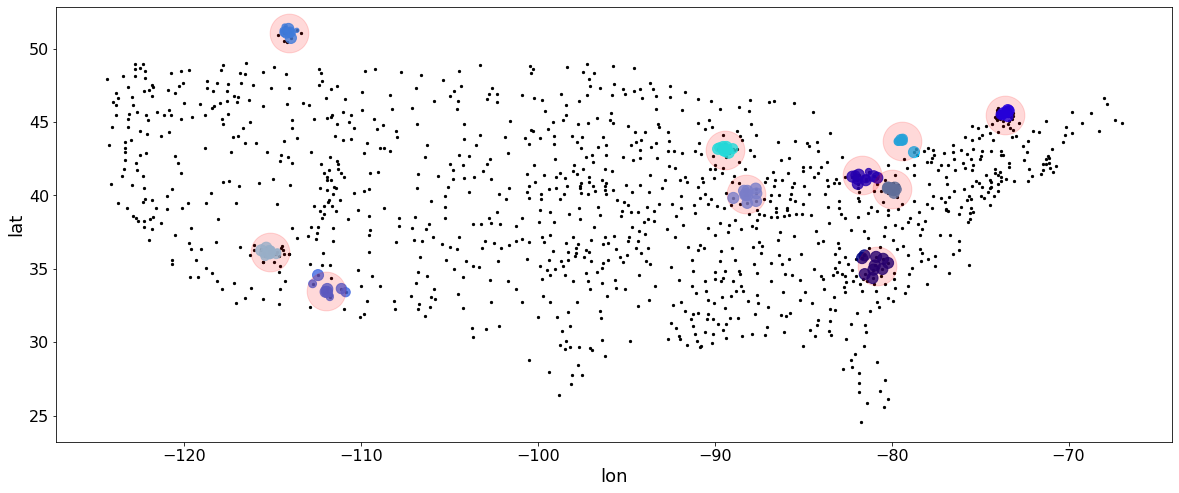

In [7]:
tmp_fig = wl.generate_control_plot()

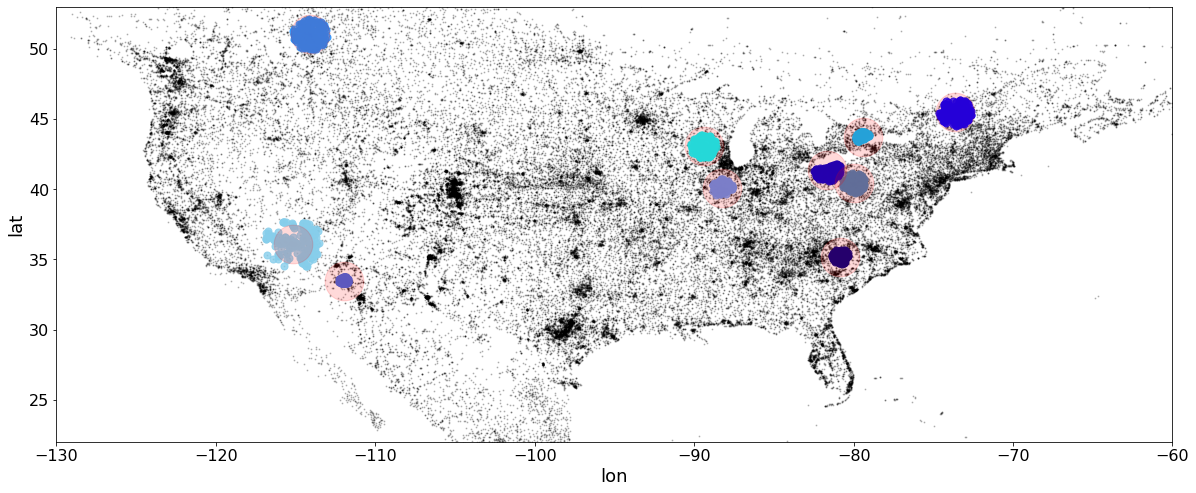

In [8]:
tmp_fig2 = wl.generate_closest_station_plot()

In [35]:
wl.best_station_data[1]

,lat,lon,name,sid,days,sqrt_days,distance,quality
16,43.6667000000,-79.4000000000,TORONTO,CA006158350,2348,48.456166,0.055108,15955.894384
23,43.7833000000,-79.4667000000,TORONTO NORTH YORK,CA00615S001,6149,78.415560,0.079308,12467.243031
20,43.7000000000,-79.3333000000,TORONTO EAST YORK DUSTAN,CA006158751,2989,54.671748,0.097010,5809.432455
17,43.6333000000,-79.4000000000,TORONTO ISLAND A,CA006158665,819,28.618176,0.085243,3938.439067
22,43.8667000000,-79.3667000000,TORONTO BUTTONVILLE A,CA00615HMAK,4158,64.482556,0.165701,2348.498513
15,43.8833000000,-79.4500000000,RICHMOND HILL,CA006157012,2220,47.116876,0.171229,1607.022945
19,43.6833000000,-79.6333000000,TORONTO LESTER B. PEARSON INT',CA006158733,3451,58.745213,0.206106,1382.901454
18,43.6767000000,-79.6306000000,TORONTO INTL A,CA006158731,2728,52.230259,0.204513,1248.761976
21,43.7833000000,-79.6000000000,WOODBRIDGE,CA006159575,516,22.715633,0.184405,668.006634
1220,42.9486000000,-78.7369000000,BUFFALO,USW00014733,6181,78.619336,1.031666,73.867132


In [11]:
sid_list = []
for key, value in wl.closest_station_data.items():
    sid_list.extend(value["sid"].tolist())
source_folder = "D:\ghcnd_all\ghcnd_all"
dest_folder = "D:\ghcnd_selected"

In [12]:
sid_list = list(set(sid_list).difference(set(wl.weather_df["sid"].tolist())))

In [14]:
import shutil

filelist = Path(source_folder).rglob('*.dly')
for i, path in enumerate(filelist):
    str_path = str(path)    
    find = re.search("(\w{11}).dly", str_path)
    if find is None:
        continue
    station_id = find.group(1)
    if station_id in sid_list:
        shutil.copy(str_path, dest_folder)
        
with open("new_sid.txt", "w") as f:
    f.write(str(sid_list))

In [9]:
from sql_setup.populate_db import DataPreparator
dp =  DataPreparator()

Ready to go!


In [16]:
# dp.insert_weather(folderpath=dest_folder)

Extracting data from: D:\ghcnd_selected to get weather data. This may take a while.
Reading in 1th file at: D:\ghcnd_selected\CA003020608.dly | station: CA003020608
Could not convert the TMIN/TMAX od PRCP of CA003020608
Reading in 2th file at: D:\ghcnd_selected\CA003021368.dly | station: CA003021368
Elapsed time for 'insert_many': 0.0011 seconds
Reading in 3th file at: D:\ghcnd_selected\CA003021950.dly | station: CA003021950
Elapsed time for 'insert_many': 0.0000 seconds
Reading in 4th file at: D:\ghcnd_selected\CA003022083.dly | station: CA003022083
Elapsed time for 'insert_many': 0.0000 seconds
Reading in 5th file at: D:\ghcnd_selected\CA003022092.dly | station: CA003022092
Could not convert the TMIN/TMAX od PRCP of CA003022092
Reading in 6th file at: D:\ghcnd_selected\CA003023982.dly | station: CA003023982
Elapsed time for 'insert_many': 0.0000 seconds
Reading in 7th file at: D:\ghcnd_selected\CA003024150.dly | station: CA003024150
Elapsed time for 'insert_many': 0.1808 seconds
Read

In [2]:
from sql_cleanup.closest_station import WeatherLinker

In [3]:
wl = WeatherLinker()
wl.generate_best_stations()

Elapsed time for 'querry_database': 2.7126 seconds
Elapsed time for 'querry_database': 0.0062 seconds
Elapsed time for 'querry_database': 0.3050 seconds
Ready to go!


In [39]:
def aggregate_weather(clusterid, station_data):
    dh = DatabaseHandler()
    my_dict = {
        "clusterid": clusterid,
        "stationlist": tuple(station_data["sid"].tolist()),
    }
    sql = """INSERT INTO cluster_weather (
    select 
    %(clusterid)s as clusterid,
    date, 
    round(avg(NULLIF(tmax, 'NaN')), 2) as tmax,
    round(avg(NULLIF(tmin, 'NaN')), 2) as tmin,
    round(avg(NULLIF(perception, 'NaN')),2) as perception,
    round(avg(NULLIF(snow, 'NaN')),2) as snow,
    round(avg(NULLIF(snowdepth, 'NaN')),2) as snowdepth
    from weather
    WHERE sid in %(stationlist)s and date >= '2004-01-01'
    GROUP BY date
    ORDER BY date
    )
    """
    dh.querry_database(sql, my_dict)
    

In [40]:
dic_cid_sid = wl.best_station_data

for cid, s_dataframe in dic_cid_sid.items():
    aggregate_weather(cid, s_dataframe)

Elapsed time for 'querry_database': 0.1636 seconds
Elapsed time for 'querry_database': 0.1713 seconds
Elapsed time for 'querry_database': 0.1588 seconds
Elapsed time for 'querry_database': 0.1240 seconds
Elapsed time for 'querry_database': 0.1286 seconds
Elapsed time for 'querry_database': 0.1278 seconds
Elapsed time for 'querry_database': 0.1325 seconds
Elapsed time for 'querry_database': 0.1217 seconds
Elapsed time for 'querry_database': 0.1244 seconds
Elapsed time for 'querry_database': 0.1326 seconds


In [2]:
import requests
import json

In [39]:
class CityCorrector:
    def __init__(self):
        self.__handler = DatabaseHandler()
        self.__query = self.__handler.querry_database
        self.__insert_many = self.__handler.insert_many
        self.city_df = self.__get_station_data()
        self.new_information = []
        
    def __get_station_data(self) -> pd.DataFrame:
        sql =  "SELECT bid, lon, lat, city from business"
        col = ["bid", "lon", "lat", "city"]
        data = self.__query(sql)
        return pd.DataFrame(data, columns=col)
    
    def create_city_data(self):
        print("Starting to get all city data")
        total_data  = len(self.city_df)
        steps = int(total_data/100)
        for number, (_, row) in enumerate(self.city_df.iterrows()):
            if number % steps == 0:
                print(f"{number/total_data:.0%}", end=" ")
            lon = row["lon"]
            lat = row["lat"]
            saved_city = row["city"]
            payload =  {"lon": lon, "lat": lat}
            try:
                r = requests.get("https://photon.ljansen.net/reverse", params=payload, auth=('api', 'apiuser'))
                resp = json.loads(r.text)
                city = None
                try:
                    city = resp["features"][0]["properties"]["city"]  
                except (KeyError, IndexError):
                    pass
                if city is not None and city != saved_city:
                    self.new_information.append((row["bid"], city))
            except requests.exceptions.RequestException as e:
                print(f"\n{e}")

In [40]:
cc = CityCorrector()

Elapsed time for 'querry_database': 0.7050 seconds


In [53]:
payload =  {"lon": -81.6954865000, "lat": 41.5101979000}
api_url = "https://photon.ljansen.net/reverse"
r = requests.get(api_url, params=payload, auth=('api', 'apiuser'), verify=False)
json.loads(r.text)

c:\python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'photon.ljansen.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


{'features': [{'geometry': {'coordinates': [-81.69624874336776, 41.5104377],
    'type': 'Point'},
   'type': 'Feature',
   'properties': {'osm_id': 615052755,
    'extent': [-81.6964159, 41.5105622, -81.6960788, 41.5102817],
    'country': 'United States',
    'city': '1000',
    'countrycode': 'US',
    'postcode': '44114',
    'county': 'Cuyahoga County',
    'type': 'house',
    'osm_type': 'W',
    'osm_key': 'amenity',
    'street': 'East 9th Street',
    'district': 'Warehouse District',
    'osm_value': 'pub',
    'name': 'Neuvo',
    'state': 'OH'}}],
 'type': 'FeatureCollection'}

In [18]:
time.time

<function time.time>

In [17]:
cc.print_first_properties(50)

City: Paradise             / Henderson           
City: Spring Valley        / Las Vegas           
City: Paradise             / Las Vegas           
City: Spring Valley        / Las Vegas           
City: Paradise             / Las Vegas           
City: Paradise             / Las Vegas           
City: Paradise             / Las Vegas           
City: Phoenix              / Cave Creek          
City: Peters Township      / Mc Murray           
City: Paradise             / Las Vegas           
City: Medina Township      / Medina              


In [41]:
cc.create_city_data()

Starting to get all city data
0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100% 

In [43]:
cc.new_information[0:10]

[('6D0LiZ25ek7rYb-TtJPCDw', 'Paradise'),
 ('jRKqW_O4kUfcpAYdQNrFmw', 'Spring Valley'),
 ('MZjw8RBI7dBC6G7jkQFEmA', 'Paradise'),
 ('nY9ZcdrkncyVh3ZJ4WvtwA', 'Spring Valley'),
 ('4uiijOUDzc-DeIb2XcKW_A', 'Paradise'),
 ('-NJlfv14ICeIxo-Jtz0u5w', 'Paradise'),
 ('I6ICIIZfZsp_J9hHmfhWhQ', 'Paradise'),
 ('gi5NJIpne6uDe11yT_Koxg', 'Phoenix'),
 ('AqoPBN03jZqMB-1stPya6g', 'Peters Township'),
 ('XzGRIOHD45HiGTPux-qSmw', 'Paradise')]

In [27]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

r_list = [100]*20

def download_file(times):
    data = []
    for i in range(times):
        try:
            payload =  {"lon": cc.city_df.iloc[0]["lon"], "lat": cc.city_df.iloc[0]["lat"]}
            api_url = "https://photon.ljansen.net/reverse"
            r = requests.get(api_url, params=payload, auth=('api', 'apiuser'))
            resp = json.loads(r.text)
            d = resp["features"][0]["properties"]["city"] 
            data.append(d)
        except requests.exceptions.RequestException as e:
            print(e)
    print(f"Done doing {times} times")
    return data

def runner():
    threads= []
    with ThreadPoolExecutor(max_workers=20) as executor:
        for count in r_list:
            threads.append(executor.submit(download_file, count))
           
        for task in as_completed(threads):
            print(task.result()) 

start = time.time()
runner()
print(time.time()-start)

HTTPSConnectionPool(host='photon.ljansen.net', port=443): Max retries exceeded with url: /reverse?lon=-115.1171168000&lat=36.0171469000 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028FEF6957F0>: Failed to establish a new connection: [WinError 10060] Ein Verbindungsversuch ist fehlgeschlagen, da die Gegenstelle nach einer bestimmten Zeitspanne nicht richtig reagiert hat, oder die hergestellte Verbindung war fehlerhaft, da der verbundene Host nicht reagiert hat'))
HTTPSConnectionPool(host='photon.ljansen.net', port=443): Max retries exceeded with url: /reverse?lon=-115.1171168000&lat=36.0171469000 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028FEF69BDC0>: Failed to establish a new connection: [WinError 10060] Ein Verbindungsversuch ist fehlgeschlagen, da die Gegenstelle nach einer bestimmten Zeitspanne nicht richtig reagiert hat, oder die hergestellte Verbindung war fehlerhaft, da der verbundene Host nicht reag

In [45]:
dh = DatabaseHandler()
sql = """
UPDATE business
set city = data.city
from (values %s) as data (bid, city)
where business.bid = data.bid
"""
dh.insert_many(sql, cc.new_information)

Elapsed time for 'insert_many': 40.8657 seconds


In [54]:
namelist_city = [
    ("avon", "Avon",),
    ("Bath", "Bath Township",),
    ("Brimfield", "Brimfield Township"),
    ("Bedford (Ville)", "Bedford"),
    ("Boulder City NV", "Boulder City",),
    ("Boulder City, NV", "Boulder City",),
    ("Buckeye - Shaker", "Buckeye"),
    ("Calagry", "Calgary"),
    ("calgary", "Calgary",),
    ("canonsburg", "Canonsburg",),
    ("cave creek", "Cave Creek",),
    ("cave Creek", "Cave Creek",),
    ("Cecil", "Cecil Township"),
    ("Chardom", "Chardon",),
    ("Chardon Township", "Chardon",),
    ("CHARLOTTE", "Charlotte",),
    ("Charlote", "Charlotte",),
    ("Charlotte, NC", "Charlotte",),
    ("cleveland", "Cleveland"),
    ("Cleveland OH", "Cleveland"),
    ("Cleveland OH", "Cleveland"),
    ("Cleveland (Westlake)", "Cleveland"),
    ("Clevland", "Cleveland"),
    ("Cleveland heights", "Cleveland Heights"),
    ("1000", "Cleveland"),
    ("1100", "Cleveland"),
    ("CONCORD", "Concord"),
    ("Concord Mills", "Concord"),
    ("Concord Township", "Concord"),
    ("Copley", "Copley Township"),
    ("De Forest", "DeForest"),
    ("Dollard-Des Ormeaux", "Dollard-Des-Ormeaux"),
    ("Etobicoke, ON", "Etobicoke"),
    ("Etoicoke", "Etobicoke"),
    ("Fairview", "Fairview Park"),
    ("Fort Mcdowell", "Fort McDowell"),
    ("Fort mill", "Fort Mill"),
    ("Fort  Mill", "Fort Mill"),
    ("Fort MIll", "Fort Mill"),
    ("Ft. Mill", "Fort Mill"),
    ("glendale", "Glendale"),
    ("Glendale;Peoria", "Glendale"),
    ("hudson", "Hudson"),
    ("Hiram Township", "Hiram"),
    ("Highland Hts", "Highland Heights"),
    ("Hinckley", "Hinckley Township"),
    ("Kennedy Township", "Kennedy"),
    ("Indian Land,", "Indian Land"),
    ("Indian Land, South Carolina", "Indian Land"),
    ("Kahnawake", "Kahnawá:ke"),
    ("Lagrange", "LaGrange"),
    ("LaGrange Township", "LaGrange"),
    ("LaSalle", "Lasalle"),
    ("Las vegas", "Las Vegas"),
    ("Las  Vegas", "Las Vegas"),
    ("Las Vegas ", "Las Vegas"),
    ("LAS VEGAS", "Las Vegas"),
    ("Las Vegas NV", "Las Vegas"),
    ("Las Vegas, NV", "Las Vegas"),
    ("Laval (13)", "Laval"),
    ("Laveen Village", "Laveen"),
    ("L'ile-Perrot", "L'Île-Perrot"),
    ("LITCHFIELD PK", "Litchfield Park"),
    ("Litchfield park", "Litchfield Park"),
    ("Litchfield", "Litchfield Park"),
    ("Madison WI", "Madison"),
    ("Marshall", "Marshall Township"),
    ("Mayfield Hts", "Mayfield Heights"),
    ("Mcfarland", "McFarland"),
    ("Mc Farland", "McFarland"),
    ("Mckees Rocks", "McKees Rocks"),
    ("Mc Kees Rocks", "McKees Rocks"),
    ("Mc Murray", "McMurray"),
    ("Mcmurray", "McMurray"),
    ("mentor", "Mentor"),
    ("Middleburgh Heights", "Middleburg Heights"),
    ("Middleburg Hts", "Middleburg Heights"),
    ("Middleburg Hts.", "Middleburg Heights"),
    ("monroeville", "Monroeville"),
    ("Montréa", "Montréal"),
    ("montreal", "Montréal"),
    ("Montreal", "Montréal"),
    ("Montréal-Est", "Montréal"),
    ("Montréal-Nord", "Montréal"),
    ("Montréal-Ouest", "Montréal"),
    ("Montville", "Montville Township"),
    ("Moon Townshop", "Moon Township"),
    ("Moon", "Moon Township"),
    ("moon", "Moon Township"),
    ("N E Las Vegas", "Las Vegas"),
    ("Nellis Afb", "Nellis AFB"),
    ("NELLIS AFB", "Nellis AFB"),
    ("Nellis Air Force Base", "Nellis AFB"),
    ("Neville Township", "Neville"),
    ("Notre-Dame-de-l'Ile-Perrot", "Notre-Dame-de-l'Île-Perrot"),
    ("Olmsted Tiownship", "Olmsted Township"),
    ("Orange Village", "Orange"),
    ("Parradise Valley", "Paradise Valley"),
    ("Peoria, AZ", "Peoria"),
    ("PeoriaPeoria", "Peoria"),
    ("Perry Twp", "Perry"),
    ("phoenix", "Phoenix"),
    ("Phonenix", "Phoenix"),
    ("pickering", "Pickering"),
    ("Pittsburgh;Upper St. Clair", "Pittsburgh"),
    ("plum", "Plum"),
    ("Richfield Township", "Richfield"),
    ("Richmond Hill (Oak Ridges)", "Richmond Hill"),
    ("Robinson", "Robinson Townshipy"),
    ("Rocky river", "Rocky River"),
    ("Rockyview", "Rocky View"),
    ("Rockyview County", "Rocky View"),
    ("Rocky View County", "Rocky View"),
    ("Rocky View No. 44", "Rocky View"),
    ("Saint-Bruno", "Saint-Bruno-de-Montarville"),
    ("Saint Laurent", "Saint-Laurent"),
    ("Sheffield Village", "Sheffield Township"),
    ("South Park", "South Park Township"),
    ("St Joseph", "St. Joseph"),
    ("Sun", "Sun City"),
    ("surprise", "Surprise"),
    ("Tempe, AZ", "Tempe"),
    ("toronto", "Toronto"),
    ("Torontoitalian", "Toronto"),
    ("Toronto;Scarborough", "Toronto"),
    ("Toronto;Torornto", "Toronto"),
    ("Upper St Clair", "Upper St. Clair"),
    ("Vaughan (Maple)", "Vaughan"),
    ("York, Toronto", "York"),
    ("York Township", "York"),  
]


In [55]:
for (old, new) in namelist_city:
    sql = "UPDATE business set city = %(newcity)s where city = %(oldcity)s"
    dat = {"newcity": new, "oldcity": old}
    dh.querry_database(sql, dat)

Elapsed time for 'querry_database': 0.0382 seconds
Elapsed time for 'querry_database': 0.0316 seconds
Elapsed time for 'querry_database': 0.0311 seconds
Elapsed time for 'querry_database': 0.0260 seconds
Elapsed time for 'querry_database': 0.0302 seconds
Elapsed time for 'querry_database': 0.0285 seconds
Elapsed time for 'querry_database': 0.0249 seconds
Elapsed time for 'querry_database': 0.0299 seconds
Elapsed time for 'querry_database': 0.0312 seconds
Elapsed time for 'querry_database': 0.0293 seconds
Elapsed time for 'querry_database': 0.0329 seconds
Elapsed time for 'querry_database': 0.0235 seconds
Elapsed time for 'querry_database': 0.0256 seconds
Elapsed time for 'querry_database': 0.0244 seconds
Elapsed time for 'querry_database': 0.0266 seconds
Elapsed time for 'querry_database': 0.0317 seconds
Elapsed time for 'querry_database': 0.0247 seconds
Elapsed time for 'querry_database': 0.0289 seconds
Elapsed time for 'querry_database': 0.0299 seconds
Elapsed time for 'querry_databa

In [5]:
de = DatabaseExecutor()

In [3]:
dh = DatabaseHandler()

In [3]:
df = dh.pandas_querry("select * from business limit 100")
df

Elapsed time for 'pandas_querry': 0.2399 seconds


,bid,clusterid,city,state,pcode,lon,lat,stars,revcount,name
0,M_guz7Dj7hX0evS672wIwA,10,City of Middleton,WI,53562,-89.510142,43.105310,3.5,6,Chocolate Shoppe Ice Cream
1,uZuh51lXu7tsrC8RAwkg1A,2,Paradise,NV,89109,-115.167608,36.125732,4.5,32,Manolo Blahnik
2,lu7vtrp_bE9PnxWfA8g4Pg,1,Markham,ON,L3T 5W4,-79.398466,43.820492,4.5,7,Banzai Sushi
3,pcaQDBM6r0PWTXfYZK6RdA,8,Montréal,QC,H8P 1B4,-73.611934,45.425645,3.0,6,IGA Extra
4,03x6ZlJ7s39DHqfTJU1Ecg,9,Orange,OH,44122,-81.470127,41.461448,4.5,7,Beechmont Country Club
...,...,...,...,...,...,...,...,...,...,...
95,EOte65_oorceNd--lvblJQ,1,Toronto,ON,M1R 2T4,-79.300091,43.763786,4.0,8,Manorhouse Furniture Sales
96,Uhbxoo_qDJPc0dFyfuvHqQ,9,Elyria Township,OH,44035,-82.130646,41.400757,2.5,3,AAA Appliance Service
97,twaYBOGSIeOvJdx8EFBKeg,1,Toronto,ON,M2K 1C3,-79.374812,43.769654,3.0,56,Sunshine Spot Restaurant
98,9qIYkSU-g_AsZhu36je6Vg,1,New Tecumseth,ON,L0G 1W0,-79.805554,44.022804,2.5,3,A G Secure Property Management


In [3]:
sql = """ SELECT popage.fcode, popage.age_range, popage.percentage, popyear.population
             FROM fip_population_age popage
             INNER JOIN fip_population_year popyear
             ON popage.fcode = popyear.fcode 
             WHERE popyear.year = 2019"""

df_age = dh.querry_database(sql)
cols = ["fcode", "age_range", "percentage", "population"]
df_age = pd.DataFrame(df_age, columns=cols)


Elapsed time for 'querry_database': 1.4239 seconds


In [4]:
df_age.head()

,fcode,age_range,percentage,population
0,01001,age_20_24,0.056883,55869
1,01001,age_5_9,0.062020,55869
2,01001,age_45_49,0.069394,55869
3,01001,age_80_84,0.021103,55869
4,01001,age_60_64,0.060320,55869


In [5]:
db_exec = DatabaseExecutor()

df_race = db_exec.get_pop_race_cluster()
df_age = db_exec.get_pop_age_cluster()

df_b = db_exec.get_pop_cluster((1,2,3,4,5,6,7,8,9,10))
clusterpop = df_b.drop_duplicates(subset=['fcode'], keep='first')

Elapsed time for 'querry_database': 0.4355 seconds
Elapsed time for 'querry_database': 0.7895 seconds
Elapsed time for 'querry_database': 4.2919 seconds


In [7]:
df_race.head()

,fcode,race,percentage,fip_pop,fip_race_pop
0,01001,black_female,0.107394,55869,6000
1,01001,hispanic_female,0.014087,55869,787
2,01001,asian_female,0.006623,55869,370
3,01001,white_female,0.377258,55869,21077
4,01001,asian_male,0.005119,55869,286


In [10]:
df_age.head()

,fcode,age_range,percentage,fip_pop,new_age_range,fip_age_pop
0,01001,age_20_24,0.056883,55869,age 20-29,3178
1,01001,age_5_9,0.062020,55869,age 5-9,3465
2,01001,age_45_49,0.069394,55869,age 30-49,3877
3,01001,age_80_84,0.021103,55869,age 65+,1179
4,01001,age_60_64,0.060320,55869,age 50-64,3370


In [11]:
df_b.head()

,stars,clusterid,bid,pcode,city,fcode,population,year
0,3.5,5,VGcV3yStTzGaOrW9CsDx-Q,28037,Denver,37109,86111,2019
1,4.5,1,IVkEpFjsUxnlihWeDU6EQw,85209,Mesa,04013,4485414,2019
2,3.0,1,u8ega20C8Bi4LRo2cZWz1w,85382,Peoria,04013,4485414,2019
3,2.5,2,EQtZN79BJBiuNFEfEMEH3w,44134,Parma,39035,1235072,2019
4,3.0,1,8WA2kwCm7AEcDPTJaJjVuQ,85282,Tempe,04013,4485414,2019


In [12]:
erg = df_race.merge(clusterpop, on='fcode', how='inner')

In [14]:
erg.head()

,fcode,race,percentage,fip_pop,fip_race_pop,stars,clusterid,bid,pcode,city,population,year
0,01081,asian_male,0.021964,164542,3614,4.5,1,ZPNYbpwFz0eqcQw40ghMPA,36867,Phoenix,164542,2019
1,01081,hispanic_female,0.017467,164542,2874,4.5,1,ZPNYbpwFz0eqcQw40ghMPA,36867,Phoenix,164542,2019
2,01081,black_female,0.123525,164542,20325,4.5,1,ZPNYbpwFz0eqcQw40ghMPA,36867,Phoenix,164542,2019
3,01081,black_male,0.105827,164542,17413,4.5,1,ZPNYbpwFz0eqcQw40ghMPA,36867,Phoenix,164542,2019
4,01081,hispanic_male,0.019551,164542,3217,4.5,1,ZPNYbpwFz0eqcQw40ghMPA,36867,Phoenix,164542,2019


In [15]:
race = erg.groupby(['clusterid', 'race'])['fip_race_pop'].sum().reset_index()

In [17]:
race.head()

,clusterid,race,fip_race_pop
0,1,asian_female,1954304
1,1,asian_male,1801722
2,1,black_female,1925190
3,1,black_male,1694086
4,1,hispanic_female,3981737


In [22]:
popcluster = []
for i in range(1, 11):
    popcluster.append(race[race.clusterid == i].fip_race_pop.sum())
popcluster

[28884835,
 5045456,
 81795,
 86452,
 9536124,
 26178374,
 2813157,
 0,
 4100776,
 494897]

In [23]:
spalte = []
for i in range(0, len(race)):
    spalte.append(popcluster[race['clusterid'][i] - 1])
spalte

[28884835,
 28884835,
 28884835,
 28884835,
 28884835,
 28884835,
 28884835,
 28884835,
 5045456,
 5045456,
 5045456,
 5045456,
 5045456,
 5045456,
 5045456,
 5045456,
 81795,
 81795,
 81795,
 81795,
 81795,
 81795,
 81795,
 81795,
 86452,
 86452,
 86452,
 86452,
 86452,
 86452,
 86452,
 86452,
 9536124,
 9536124,
 9536124,
 9536124,
 9536124,
 9536124,
 9536124,
 9536124,
 26178374,
 26178374,
 26178374,
 26178374,
 26178374,
 26178374,
 26178374,
 26178374,
 2813157,
 2813157,
 2813157,
 2813157,
 2813157,
 2813157,
 2813157,
 2813157,
 4100776,
 4100776,
 4100776,
 4100776,
 4100776,
 4100776,
 4100776,
 4100776,
 494897,
 494897,
 494897,
 494897,
 494897,
 494897,
 494897,
 494897]

In [25]:
series = pd.Series(spalte)
race['popcluster'] = series
race.head(20)

,clusterid,race,fip_race_pop,popcluster
0,1,asian_female,1954304,28884835
1,1,asian_male,1801722,28884835
2,1,black_female,1925190,28884835
3,1,black_male,1694086,28884835
4,1,hispanic_female,3981737,28884835
5,1,hispanic_male,4046717,28884835
6,1,white_female,6795818,28884835
7,1,white_male,6685261,28884835
8,2,asian_female,64610,5045456
9,2,asian_male,60764,5045456


In [26]:
race['popcluster'] = race["fip_race_pop"].groupby(race['clusterid']).transform('sum')
race.head(20)

,clusterid,race,fip_race_pop,popcluster
0,1,asian_female,1954304,28884835
1,1,asian_male,1801722,28884835
2,1,black_female,1925190,28884835
3,1,black_male,1694086,28884835
4,1,hispanic_female,3981737,28884835
5,1,hispanic_male,4046717,28884835
6,1,white_female,6795818,28884835
7,1,white_male,6685261,28884835
8,2,asian_female,64610,5045456
9,2,asian_male,60764,5045456


In [28]:
erg1 = df_age.merge(clusterpop, on='fcode', how='inner')
age = erg1.groupby(['clusterid', 'new_age_range'])['fip_age_pop'].sum().reset_index()
age.head()

,clusterid,new_age_range,fip_age_pop
0,1,age 0-4,1807736
1,1,age 10-14,1884755
2,1,age 15-19,1846429
3,1,age 20-29,4217076
4,1,age 30-49,8092860


In [29]:
popcluster1 = []
for i in range(1, 11):
    # print(age[age.clusterid == i].fip_age_pop.sum() / 1000000)
    popcluster1.append(age[age.clusterid == i].fip_age_pop.sum())
spalte1 = []
for i in range(0, len(age)):
    spalte1.append(popcluster1[age['clusterid'][i] - 1])
series1 = pd.Series(spalte1)
age['popcluster'] = series1
age.head(20)

,clusterid,new_age_range,fip_age_pop,popcluster
0,1,age 0-4,1807736,29520825
1,1,age 10-14,1884755,29520825
2,1,age 15-19,1846429,29520825
3,1,age 20-29,4217076,29520825
4,1,age 30-49,8092860,29520825
5,1,age 5-9,1835927,29520825
6,1,age 50-64,5362352,29520825
7,1,age 65+,4473690,29520825
8,2,age 0-4,296226,5133571
9,2,age 10-14,311290,5133571


In [31]:
age['popcluster'] = age["fip_age_pop"].groupby(age['clusterid']).transform('sum')
age.head(20)

,clusterid,new_age_range,fip_age_pop,popcluster
0,1,age 0-4,1807736,29520825
1,1,age 10-14,1884755,29520825
2,1,age 15-19,1846429,29520825
3,1,age 20-29,4217076,29520825
4,1,age 30-49,8092860,29520825
5,1,age 5-9,1835927,29520825
6,1,age 50-64,5362352,29520825
7,1,age 65+,4473690,29520825
8,2,age 0-4,296226,5133571
9,2,age 10-14,311290,5133571
